In [11]:
import numpy as np
import optimizers
import measures
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
X, y = make_moons()

In [2]:
class LogReg:
    def __init__(self, optimization, **kwargs):
        self.optimization = optimization
        self.kwargs=kwargs
        self.losses = None
        self.is_trained = False
        self.__is_optimization_known(optimization)
        if optimization == 'Gradient Descent':
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Stochastic Gradient Descent':
            self.kwargs['batch_size'] = 1
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Iterative Reweighted Least Squares':
            self.__optimizer = optimizers.IRLS(**self.kwargs)
        elif optimization == 'Adaptive Moment Estimation':
            self.__optimizer = optimizers.ADAM(**self.kwargs)
            
    @staticmethod
    def __is_optimization_known(o):
        if o not in ['Gradient Descent', 'Stochastic Gradient Descent',
                     'Iterative Reweighted Least Squares', 'Adaptive Moment Estimation']:
            raise ValueError(f'Unknown optimization {o}')

    def train(self, X, y):
        #todo: check the dimensions?
        self.__optimizer.train(X, y)
        
    def predict(self, X):
        return self.__optimizer.predict(X)
    
    def get_optimizer_training_losses(self):
        return self.__optimizer.losses
    def get_optimizer_training_w(self):
        return self.__optimizer.w

In [3]:
lr_gd = LogReg(optimization='Gradient Descent', learning_rate=0.01, epochs=50, batch_size=10)

In [4]:
lr_gd.train(X, y)

In [5]:
lr_sgd = LogReg(optimization='Stochastic Gradient Descent', learning_rate=0.01, epochs=50)

In [6]:
lr_sgd.train(X, y)

In [7]:
lr_irls = LogReg(optimization='Iterative Reweighted Least Squares', epochs=50)
lr_irls.train(X, y)

In [8]:
lr_adam = LogReg(optimization='Adaptive Moment Estimation',
                             epochs=50,
                             learning_rate=0.01,
                             beta_1=0.9,
                             beta_2=0.99,
                             epsilon=1e-8
                            )
lr_adam.train(X, y)

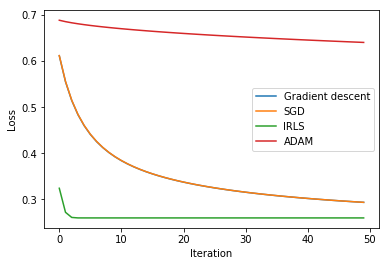

In [9]:
l_gd = lr_gd.get_optimizer_training_losses()
l_sgd = lr_sgd.get_optimizer_training_losses()
l_irls=lr_irls.get_optimizer_training_losses()
l_adam=lr_adam.get_optimizer_training_losses()
plt.plot(range(len(l_gd)), l_gd, label='Gradient descent')
plt.plot(range(len(l_sgd)), l_sgd, label='SGD')
plt.plot(range(len(l_irls)), l_irls, label='IRLS')
plt.plot(range(len(l_adam)), l_adam, label='ADAM')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [10]:
p_gd = lr_gd.predict(X)
p_sgd = lr_sgd.predict(X)
p_irls=lr_irls.predict(X)
p_adam=lr_adam.predict(X)

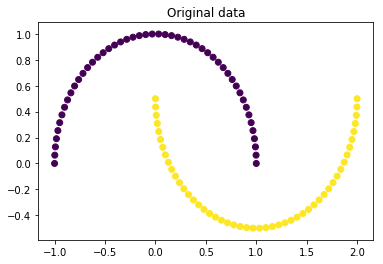

In [11]:
plt.scatter(*X.T, c=y)
plt.title('Original data')
plt.show()

accuracy:  0.8


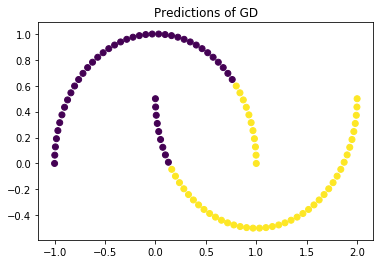

In [12]:
print("accuracy: ",np.mean(p_gd==y))
plt.scatter(*X.T, c=p_gd)
plt.title('Predictions of GD')
plt.show()

accuracy:  0.85


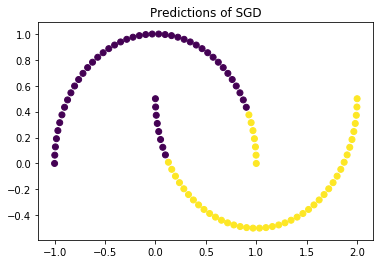

In [13]:
print("accuracy: ",np.mean(p_sgd==y))
plt.scatter(*X.T, c=p_sgd)
plt.title('Predictions of SGD')
plt.show()

accuracy:  0.88


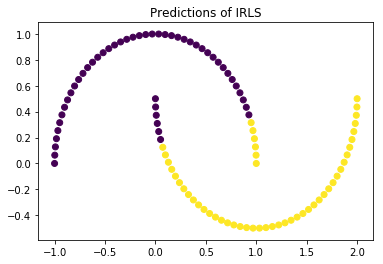

In [14]:
print("accuracy: ",np.mean(p_irls==y))
plt.scatter(*X.T, c=p_irls)
plt.title('Predictions of IRLS')
plt.show()

accuracy:  0.8


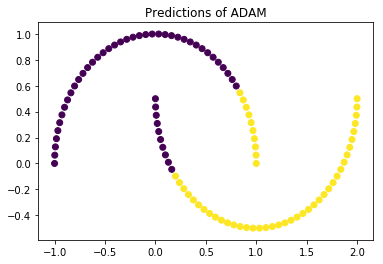

In [15]:
print("accuracy: ",np.mean(p_adam==y))
plt.scatter(*X.T, c=p_adam)
plt.title('Predictions of ADAM')
plt.show()

In [25]:
from sklearn.datasets import make_blobs

In [82]:
b, p = make_blobs(centers=2, cluster_std=3.5, n_samples=1000)

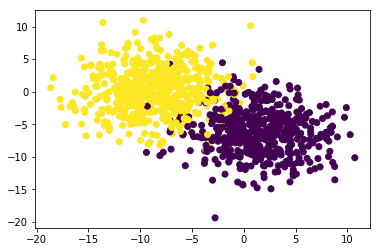

In [83]:
plt.scatter(*b.T, c=p)

In [84]:
l = LogReg('Gradient Descent', batch_size=8, epochs=20, learning_rate=0.1)

In [85]:
l.train(b[:800,], p[:800])

Early stopping



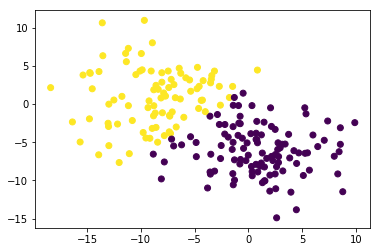

In [87]:
plt.scatter(*b[800:].T, c=l.predict(b[800:]))

In [88]:
ls= LogReg('Stochastic Gradient Descent', batch_size=8, epochs=20, learning_rate=0.1)

In [89]:
ls.train(b[:800,], p[:800])

Early stopping



In [91]:
measures.accuracy(ls.predict(b[800:]), p[800:])

0.94

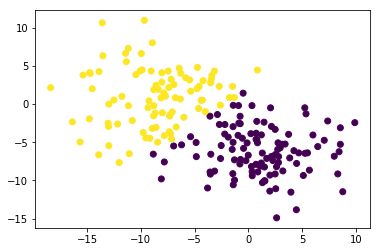

In [90]:
plt.scatter(*b[800:].T, c=ls.predict(b[800:]))